# Clustering 3K PBMCs

In May 2017, this started out as a demonstration that Scanpy would allow to reproduce most of Seurat's ([Satija et al., 2015](https://doi.org/10.1038/nbt.3192)) [Guided Clustering Tutorial](http://satijalab.org/seurat/pbmc3k_tutorial.html). We gratefully acknowledge the authors of Seurat for the tutorial. In the meanwhile, we have added and removed a few pieces.

**Note**: Download the notebook by clicking on the _Edit on GitHub_ button. On GitHub, you can download using the _Raw_ button via right-click and _Save Link As_. Alternatively, download the whole [scanpy-tutorial](https://github.com/theislab/scanpy-tutorials) repository.

The data consists in *3K PBMCs from a Healthy Donor* and is freely available from 10x Genomics ([here](http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz) from this [webpage](https://support.10xgenomics.com/single-cell-gene-expression/datasets/1.1.0/pbmc3k)). On a unix system, you can uncomment and run the following to download and unpack the data

In [111]:
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz

**Note:** In notebooks and jupyter lab, you can see the documentation for a python function by hitting ``SHIFT + TAB``. Hit it twice to expand the view.

In [389]:
%load_ext autoreload
%autoreload 2

from importlib import reload
import numpy as np
import pandas as pd
import scanpy as sc
import desc.models as desc
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis results

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.3.7 anndata==0.6.17 numpy==1.15.4 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


In [370]:
sc.settings.set_figure_params(dpi=80)

In [439]:
adata = sc.read_10x_mtx(
    'desc/datasets/pbmc',  # the directory with the `.mtx` file
    var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
    cache=True)                                # write a cache file for faster subsequent reading

... reading from cache file ./cache/desc-datasets-pbmc-matrix.h5ad


In [440]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

## Preprocessing

Basic filtering.

In [441]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [442]:
mito_genes = adata.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

A violin plot of the computed quality measures.

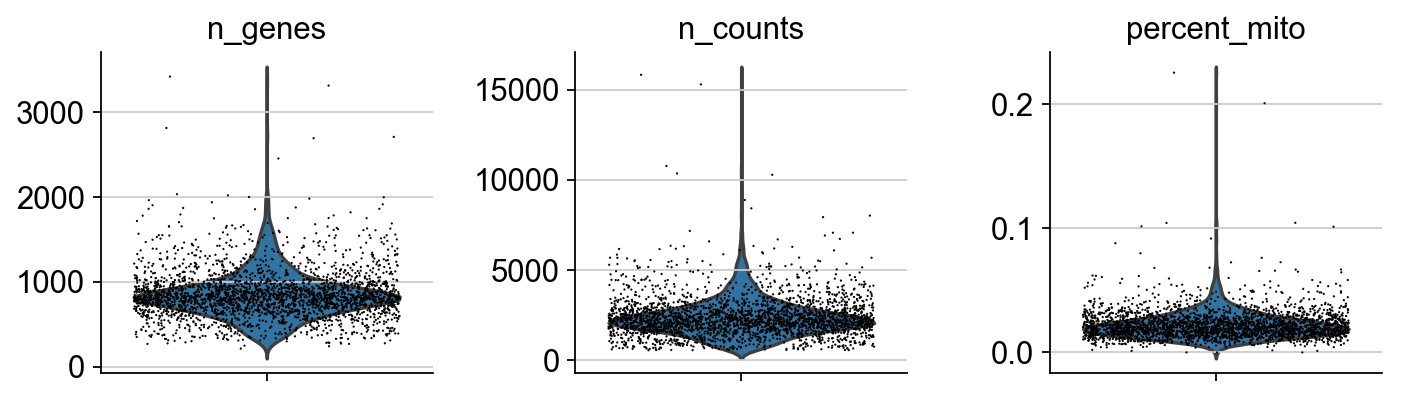

In [443]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

Remove cells that have too many mitochondrial genes expressed or too many total counts.

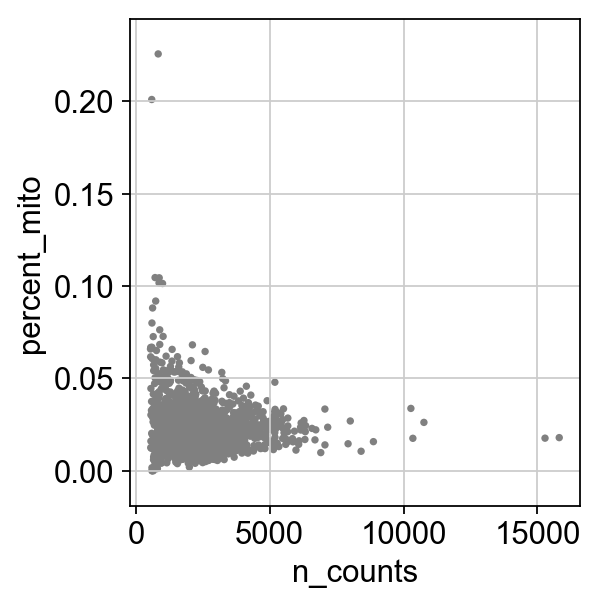

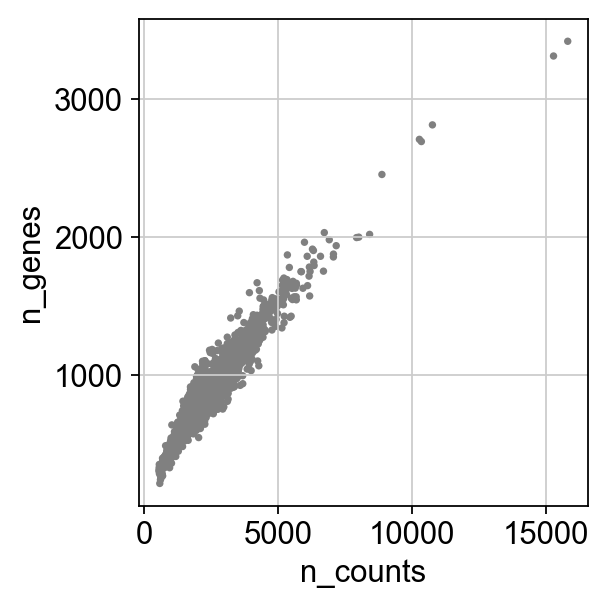

In [444]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Actually do the filtering.

In [445]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Total-count normalize (library-size correct): x / total umi in cell * median(umi all cells)

In [446]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

Identify highly-variable genes.

In [447]:
data = adata.X.todense()
data = data[:,np.where(np.sum(data,axis=0) > 10)[1]]
data[np.nonzero(data) == False] = np.nan
highly_var_genes = np.nanvar(data,axis=0).tolist()[0]
highly_var_genes_idx = np.argsort(highly_var_genes)
highly_var_genes_idx = highly_var_genes_idx[-1000:]
adata = adata[:,highly_var_genes_idx]

In [367]:
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var['highly_variable']]
sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])
sc.pp.scale(adata, max_value=10)

--> added
    'highly_variable', boolean vector (adata.var)
    'means', boolean vector (adata.var)
    'dispersions', boolean vector (adata.var)
    'dispersions_norm', boolean vector (adata.var)
regressing out ['n_counts', 'percent_mito']
    sparse input is densified and may lead to high memory use
    finished (0:00:00.38)


In [448]:
adata

View of AnnData object with n_obs × n_vars = 2638 × 1000 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

## Principal component analysis

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [381]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

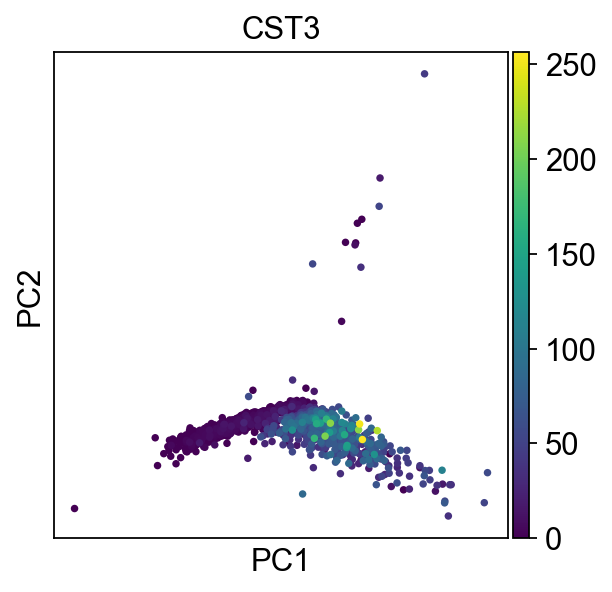

In [382]:
sc.pl.pca(adata, color='CST3')

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function  `sc.tl.louvain()` or tSNE `sc.tl.tsne()`. In our experience, often, a rough estimate of the number of PCs does fine.

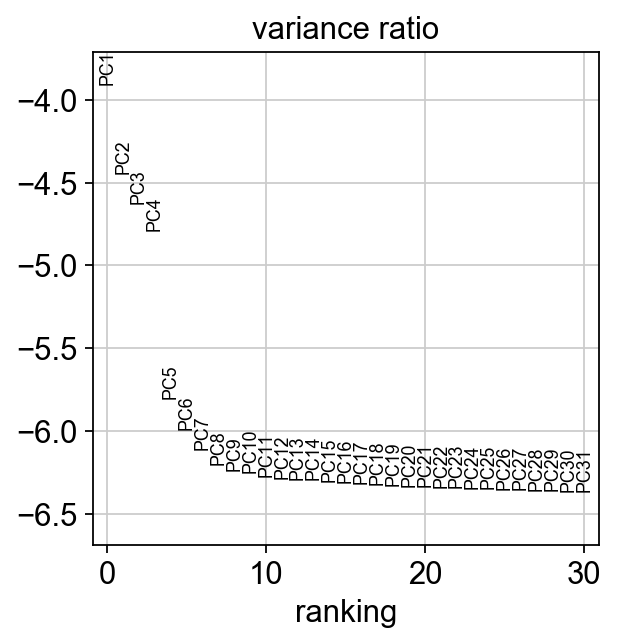

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)

Save the result.

In [23]:
adata.write(results_file)

In [24]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

In [25]:
adata.obsm['X_pca'].shape

(2638, 50)

## Computing the neighborhood graph

Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat's results, let's take the following values.

In [26]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:03.40) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix


## Embedding the neighborhood graph

We advertise embedding the graph in 2 dimensions using UMAP ([McInnes et al., 2018](https://arxiv.org/abs/1802.03426)), see below. It is  potentially more faithful to the global connectivity of the manifold than tSNE, i.e., it better preservers trajectories. In some ocassions, you might still observe disconnected clusters and similar connectivity violations. They can usually be remedied by running:

```
tl.paga(adata)
pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
tl.umap(adata, init_pos='paga')
```

In [27]:
sc.tl.umap(adata)

computing UMAP
    finished (0:00:03.71) --> added
    'X_umap', UMAP coordinates (adata.obsm)


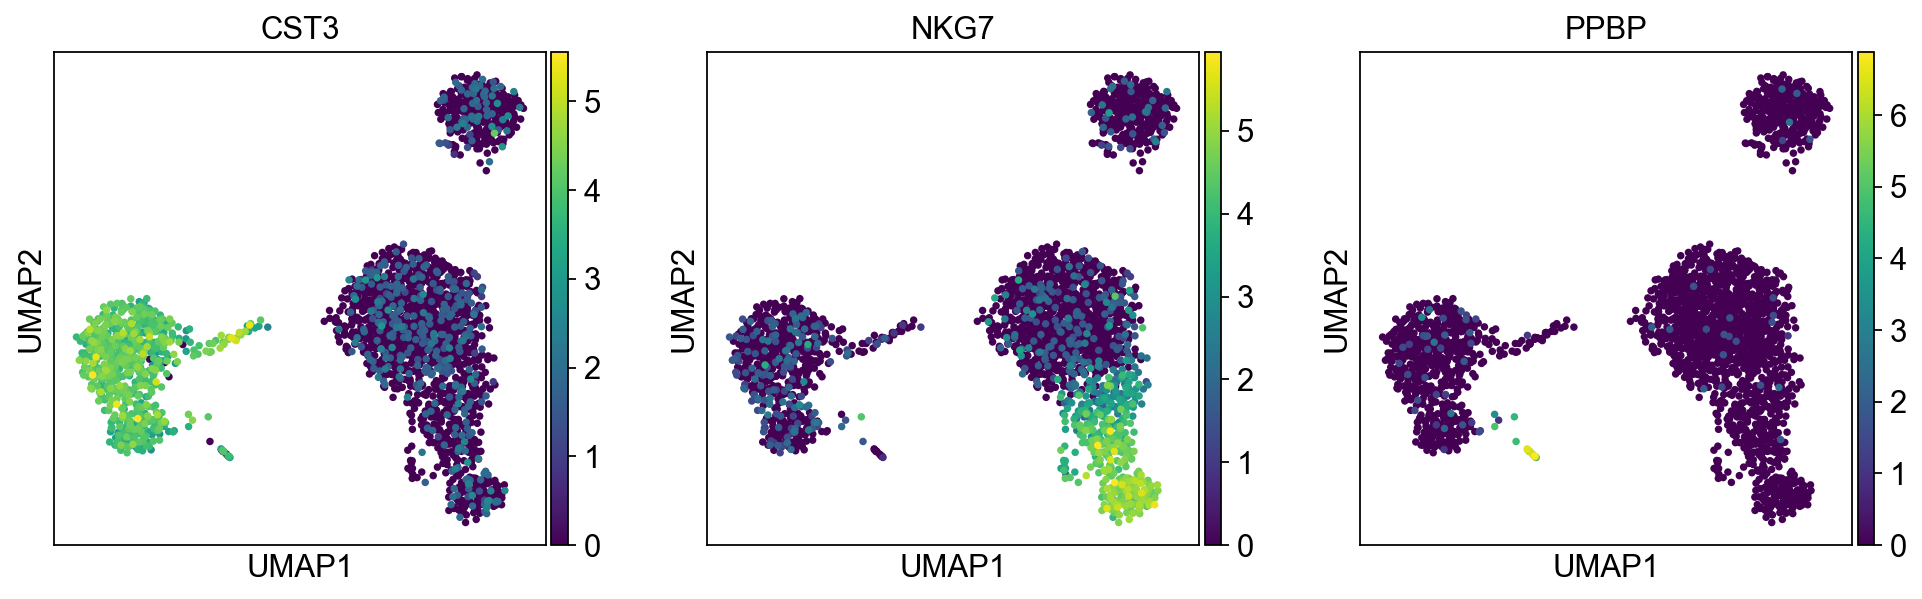

In [28]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

As we set the `.raw` attribute of `adata`, the previous plots showed the "raw" (normalized, logarithmized, but uncorrected) gene expression. You can also plot the scaled and corrected gene expression by explicitly stating that you don't want to use `.raw`.

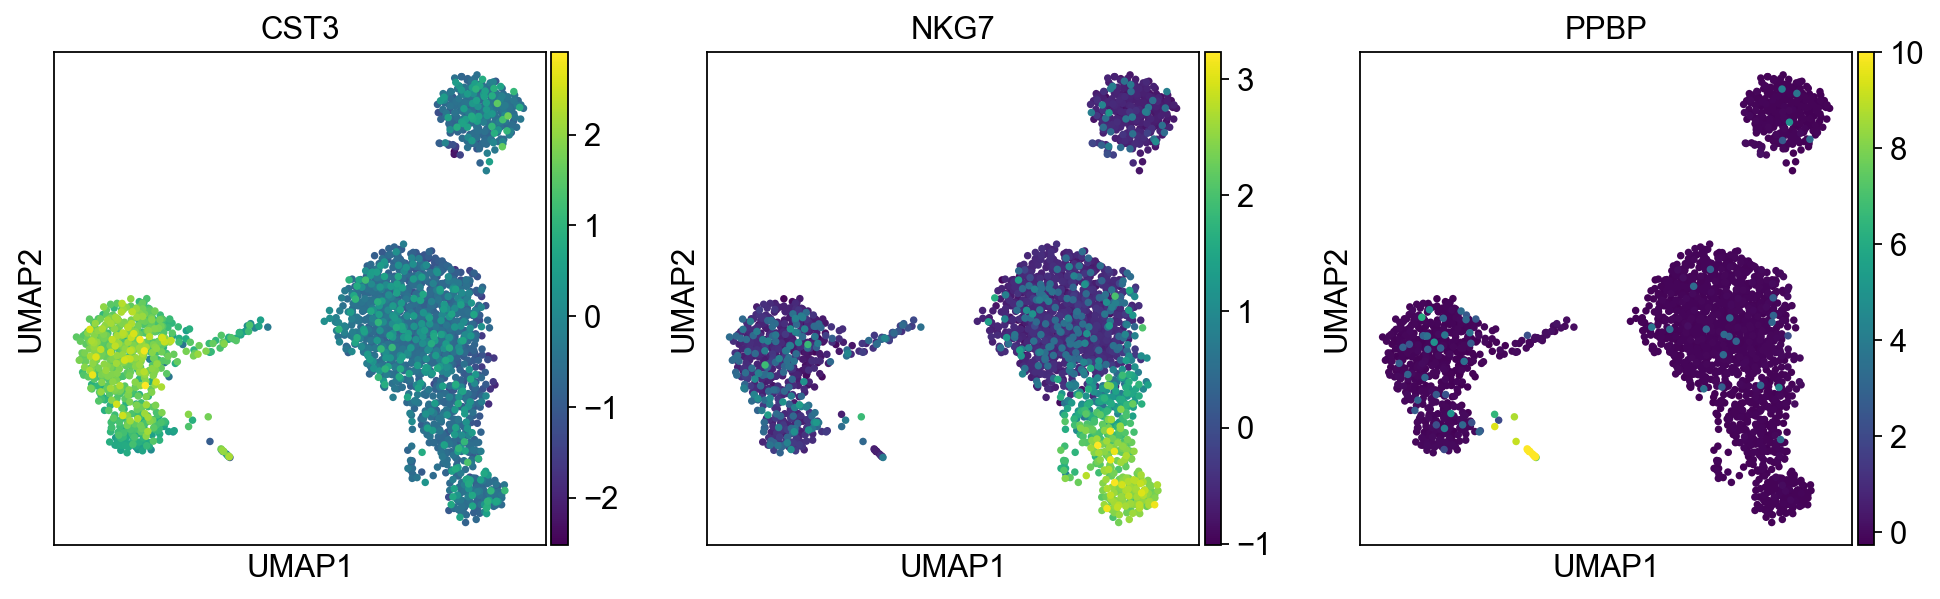

In [29]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'], use_raw=False)

## Clustering the neighborhood graph

As Seurat and many others, we recommend the Louvain graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by [Levine et al. (2015)](https://doi.org/10.1016/j.cell.2015.05.047). Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [30]:
sc.tl.louvain(adata)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.15) --> found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


Plot the clusters, which agree quite well with the result of Seurat.

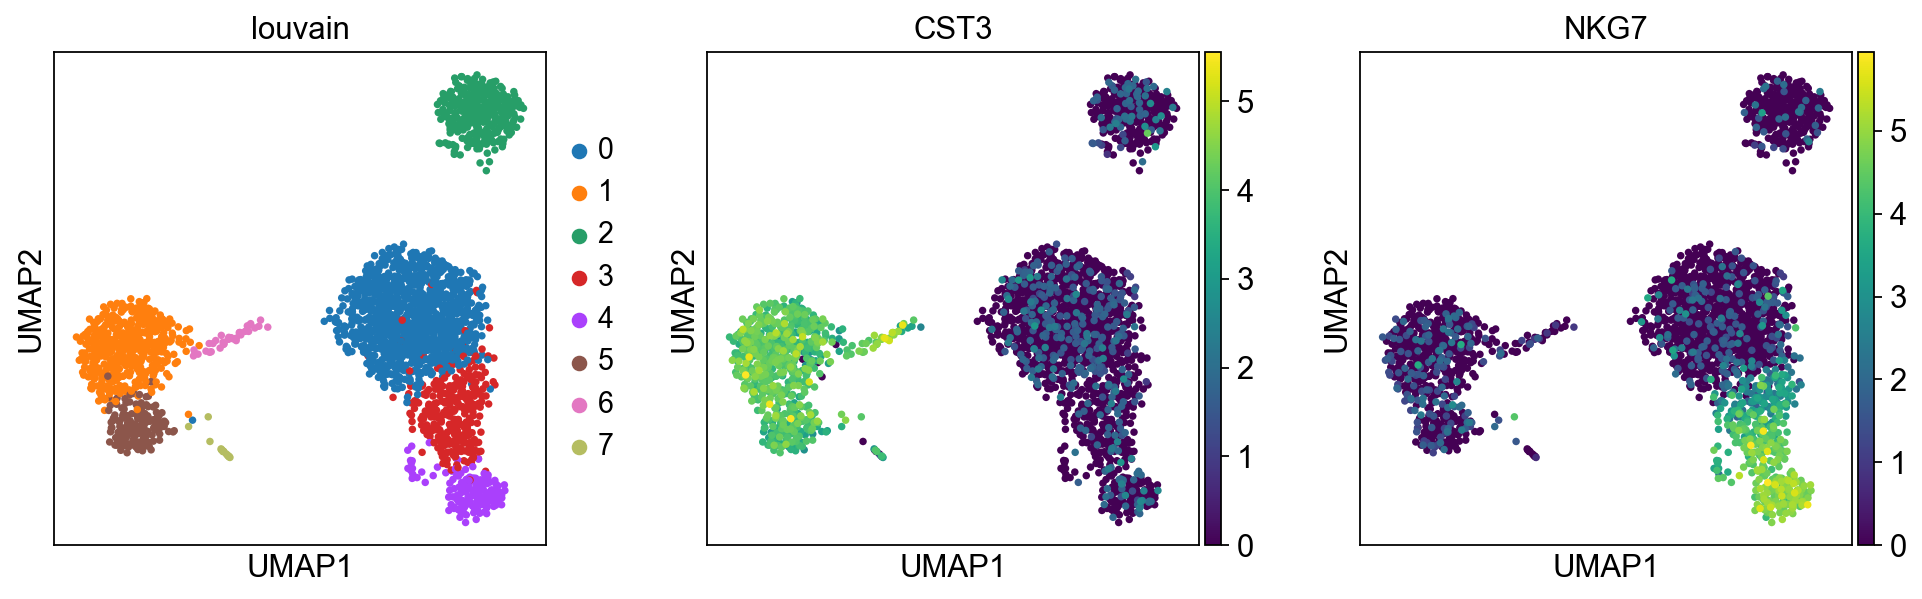

In [31]:
sc.pl.umap(adata, color=['louvain', 'CST3', 'NKG7'])

Save the result.

In [32]:
adata.write(results_file)

## Plot the clusters with TSNE

In [33]:
sc.tl.tsne(adata)

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:17.09) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


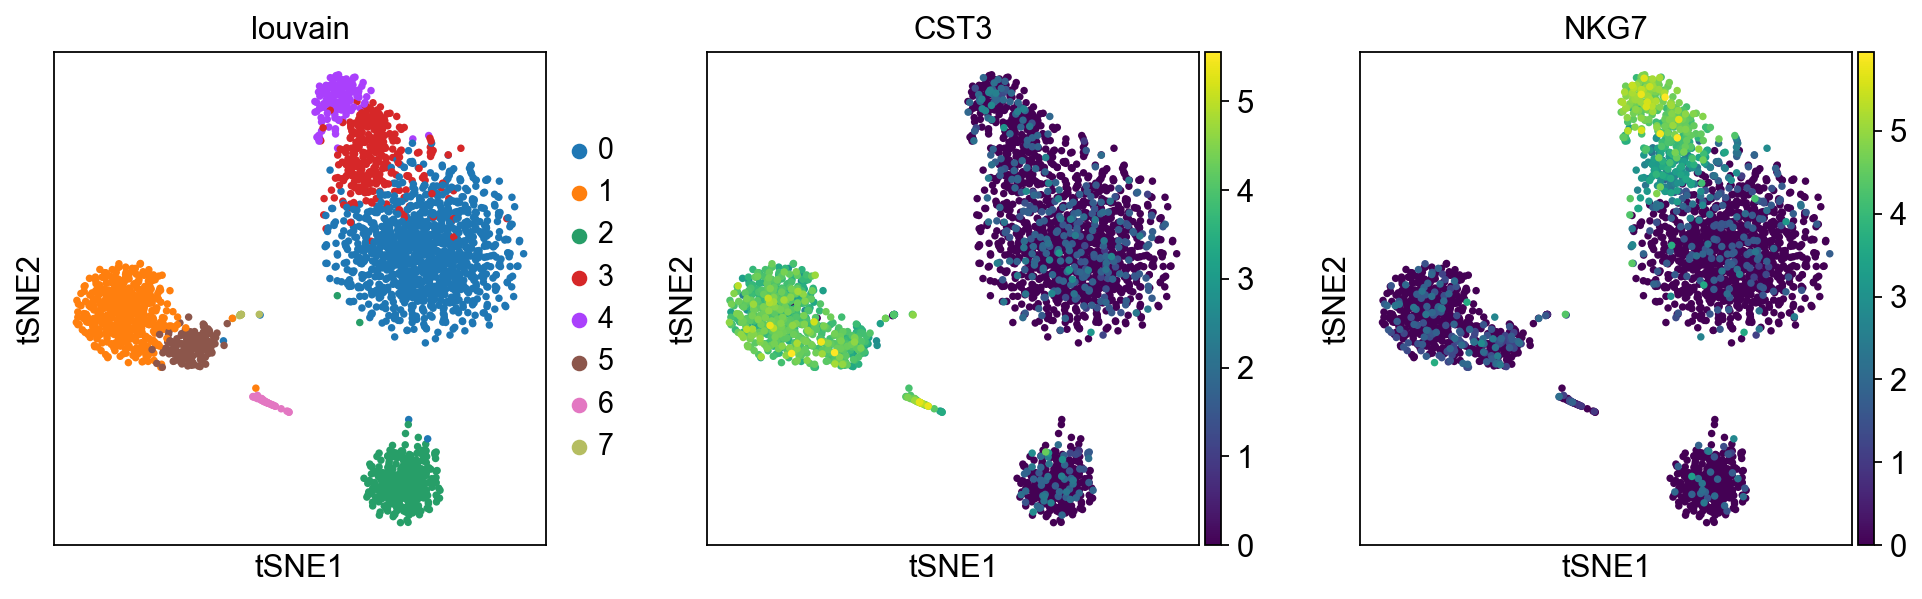

In [34]:
sc.pl.tsne(adata, color=['louvain', 'CST3', 'NKG7'])

## Plot the Clusters with DESC

MSE no imputation.

In [385]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="mse",impute=False,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 1s 557us/step - loss: 36.6474
Epoch 2/300
2638/2638 [==============================] - 0s 35us/step - loss: 36.3015
Epoch 3/300
2638/2638 [==============================] - 0s 36us/step - loss: 36.2872
Epoch 4/300
2638/2638 [==============================] - 0s 37us/step - loss: 36.2833
Epoch 5/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2808
Epoch 6/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2784
Epoch 7/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2763
Epoch 8/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2749
Epoch 9/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2736
Epoch 10/300


2638/2638 [==============================] - 0s 32us/step - loss: 36.2292
Epoch 93/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2283
Epoch 94/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2282
Epoch 95/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2275
Epoch 96/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2276
Epoch 97/300
2638/2638 [==============================] - 0s 35us/step - loss: 36.2272
Epoch 98/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2268
Epoch 99/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2265
Epoch 100/300
2638/2638 [==============================] - 0s 31us/step - loss: 36.2259
Epoch 101/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2259
Epoch 102/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2251
Epoch 103/300
2638/2638 [============================

2638/2638 [==============================] - 0s 35us/step - loss: 36.2036
Epoch 186/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2036
Epoch 187/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2031
Epoch 188/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2026
Epoch 189/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2026
Epoch 190/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2026
Epoch 191/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2022
Epoch 192/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2023
Epoch 193/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2019
Epoch 194/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2017
Epoch 195/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2015
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 38us/step - loss: 36.1892
Epoch 279/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1894
Epoch 280/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.1888
Epoch 281/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1891
Epoch 282/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1888
Epoch 283/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.1891
Epoch 284/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.1885
Epoch 285/300
2638/2638 [==============================] - 0s 31us/step - loss: 36.1888
Epoch 286/300
2638/2638 [==============================] - 0s 31us/step - loss: 36.1883
Epoch 287/300
2638/2638 [==============================] - 0s 31us/step - loss: 36.1884
Epoch 288/300
2638/2638 [==============================] - 0s 30us/step - loss: 36.1882
Epoch 289/300
2638/2638 [=====================

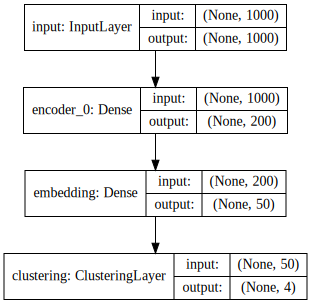

In [391]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [392]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:15.50) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


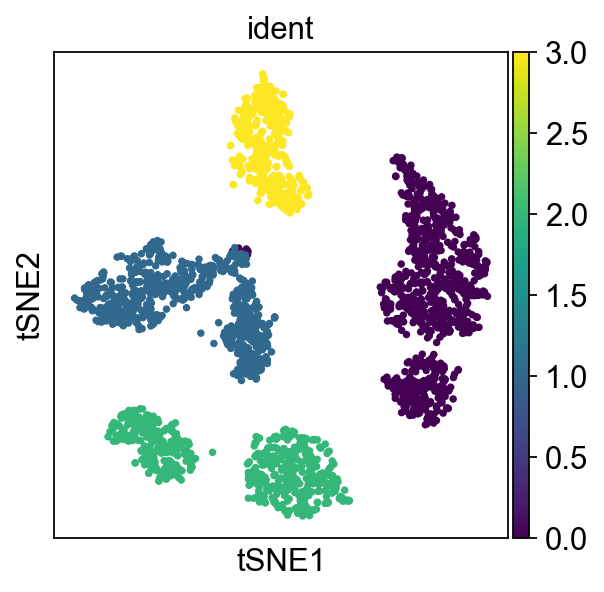

In [393]:
sc.pl.tsne(adata, color=['ident'])

MSE with imputation.

In [396]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="mse",impute=True,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 1s 459us/step - loss: 36.6474
Epoch 2/300
2638/2638 [==============================] - 0s 35us/step - loss: 36.3015
Epoch 3/300
2638/2638 [==============================] - 0s 35us/step - loss: 36.2872
Epoch 4/300
2638/2638 [==============================] - 0s 35us/step - loss: 36.2833
Epoch 5/300
2638/2638 [==============================] - 0s 38us/step - loss: 36.2808
Epoch 6/300
2638/2638 [==============================] - 0s 36us/step - loss: 36.2788
Epoch 7/300
2638/2638 [==============================] - 0s 37us/step - loss: 36.2764
Epoch 8/300
2638/2638 [==============================] - 0s 35us/step - loss: 36.2746
Epoch 9/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2737
Epoch 10/300


2638/2638 [==============================] - 0s 34us/step - loss: 36.2302
Epoch 93/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2299
Epoch 94/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2296
Epoch 95/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2292
Epoch 96/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2290
Epoch 97/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2287
Epoch 98/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2278
Epoch 99/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2276
Epoch 100/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2272
Epoch 101/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2271
Epoch 102/300
2638/2638 [==============================] - 0s 36us/step - loss: 36.2270
Epoch 103/300
2638/2638 [============================

2638/2638 [==============================] - 0s 34us/step - loss: 36.2035
Epoch 186/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2031
Epoch 187/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2034
Epoch 188/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2028
Epoch 189/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2028
Epoch 190/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2026
Epoch 191/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2023
Epoch 192/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2024
Epoch 193/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.2020
Epoch 194/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.2017
Epoch 195/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.2014
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 33us/step - loss: 36.1899
Epoch 279/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.1893
Epoch 280/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1899
Epoch 281/300
2638/2638 [==============================] - 0s 33us/step - loss: 36.1892
Epoch 282/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.1893
Epoch 283/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.1891
Epoch 284/300
2638/2638 [==============================] - 0s 34us/step - loss: 36.1893
Epoch 285/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1891
Epoch 286/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1887
Epoch 287/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1888
Epoch 288/300
2638/2638 [==============================] - 0s 32us/step - loss: 36.1887
Epoch 289/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 33us/step - loss: 36.3986 - clustering_loss: 0.1554 - output_loss: 36.2432
Epoch 2/4
2638/2638 [==============================] - 0s 34us/step - loss: 36.3757 - clustering_loss: 0.1317 - output_loss: 36.2440
Epoch 3/4
2638/2638 [==============================] - 0s 33us/step - loss: 36.3858 - clustering_loss: 0.1407 - output_loss: 36.2450
Epoch 4/4
2638/2638 [==============================] - 0s 34us/step - loss: 36.3638 - clustering_loss: 0.1187 - output_loss: 36.2452
The value of delta_label of current 11 th iteration is 0.013267626990144048 >= tol 0.005
Epoch 1/4
2638/2638 [==============================] - 0s 33us/step - loss: 36.3918 - clustering_loss: 0.1455 - output_loss: 36.2462
Epoch 2/4
2638/2638 [==============================] - 0s 34us/step - loss: 36.3752 - clustering_loss: 0.1286 - output_loss: 36.2466
Epoch 3/4
2638/2638 [==============================] - 0s 34us/step - loss: 36.3748 - clustering_loss: 0.1277 - output_loss

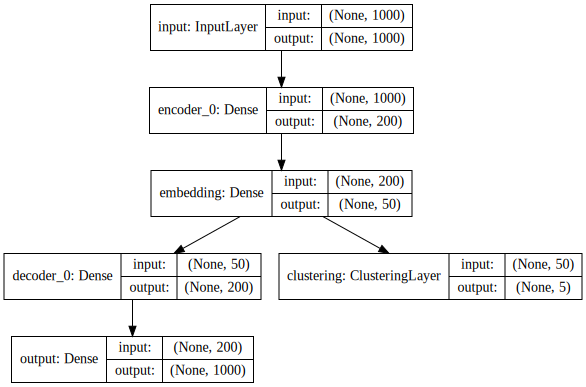

In [397]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [398]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.39) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


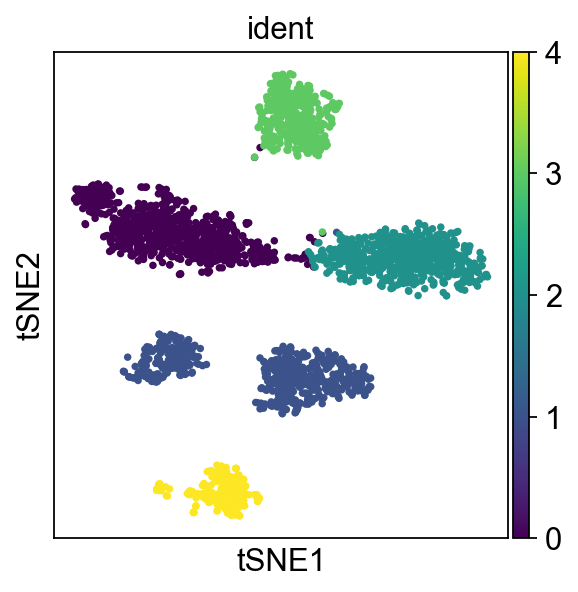

In [399]:
sc.pl.tsne(adata, color=['ident'])

NB no imputation.

In [400]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="nb",impute=False,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with negative binomial loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 2s 602us/step - loss: 0.6721
Epoch 2/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3955
Epoch 3/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3726
Epoch 4/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3672
Epoch 5/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3652
Epoch 6/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3645
Epoch 7/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3626
Epoch 8/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3619
Epoch 9/300
2638/2638 [==============================] - 0s 117us/step - loss: 0.3606
Epoch 10/300
26

2638/2638 [==============================] - 0s 108us/step - loss: 0.3361
Epoch 93/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3368
Epoch 94/300
2638/2638 [==============================] - 0s 103us/step - loss: 0.3357
Epoch 95/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3358
Epoch 96/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3356
Epoch 97/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3352
Epoch 98/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3354
Epoch 99/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3349
Epoch 100/300
2638/2638 [==============================] - 0s 105us/step - loss: 0.3346
Epoch 101/300
2638/2638 [==============================] - 0s 103us/step - loss: 0.3343
Epoch 102/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3348
Epoch 103/300
2638/2638 [============================

2638/2638 [==============================] - 0s 109us/step - loss: 0.3174
Epoch 186/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3175
Epoch 187/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3176
Epoch 188/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3169
Epoch 189/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3169
Epoch 190/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3168
Epoch 191/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3167
Epoch 192/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3163
Epoch 193/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3163
Epoch 194/300
2638/2638 [==============================] - 0s 113us/step - loss: 0.3164
Epoch 195/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3157
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 111us/step - loss: 0.3018
Epoch 279/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3021
Epoch 280/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.3010
Epoch 281/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3013
Epoch 282/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3010
Epoch 283/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3010
Epoch 284/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3010
Epoch 285/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3002
Epoch 286/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3010
Epoch 287/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3005
Epoch 288/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.2999
Epoch 289/300
2638/2638 [=====================

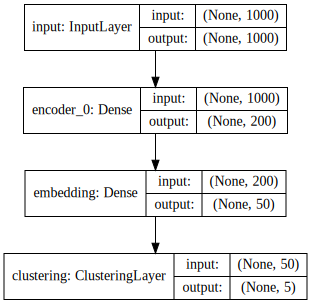

In [401]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [402]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.23) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


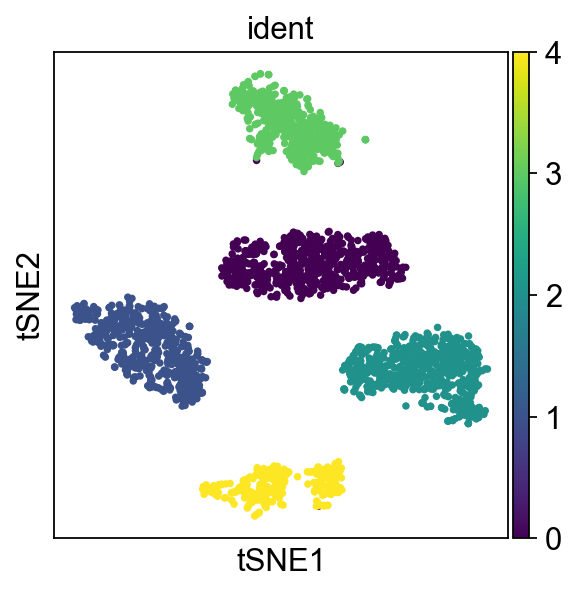

In [403]:
sc.pl.tsne(adata, color=['ident'])

NB with imputation default.

In [404]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="nb",impute=True,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with negative binomial loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 2s 619us/step - loss: 0.6718
Epoch 2/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3957
Epoch 3/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3727
Epoch 4/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3672
Epoch 5/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3653
Epoch 6/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3644
Epoch 7/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3634
Epoch 8/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3622
Epoch 9/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3609
Epoch 10/300
26

2638/2638 [==============================] - 0s 108us/step - loss: 0.3366
Epoch 93/300
2638/2638 [==============================] - 0s 105us/step - loss: 0.3365
Epoch 94/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3352
Epoch 95/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3359
Epoch 96/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3358
Epoch 97/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3352
Epoch 98/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3352
Epoch 99/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3347
Epoch 100/300
2638/2638 [==============================] - 0s 105us/step - loss: 0.3344
Epoch 101/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3347
Epoch 102/300
2638/2638 [==============================] - 0s 107us/step - loss: 0.3343
Epoch 103/300
2638/2638 [============================

2638/2638 [==============================] - 0s 113us/step - loss: 0.3170
Epoch 186/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3167
Epoch 187/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3170
Epoch 188/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3164
Epoch 189/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3161
Epoch 190/300
2638/2638 [==============================] - 0s 114us/step - loss: 0.3161
Epoch 191/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3164
Epoch 192/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3152
Epoch 193/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3160
Epoch 194/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3152
Epoch 195/300
2638/2638 [==============================] - 0s 113us/step - loss: 0.3154
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 115us/step - loss: 0.3007
Epoch 279/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3004
Epoch 280/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.3003
Epoch 281/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.3002
Epoch 282/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.2997
Epoch 283/300
2638/2638 [==============================] - 0s 113us/step - loss: 0.3001
Epoch 284/300
2638/2638 [==============================] - 0s 118us/step - loss: 0.2994
Epoch 285/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.2994
Epoch 286/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.2993
Epoch 287/300
2638/2638 [==============================] - 0s 112us/step - loss: 0.2996
Epoch 288/300
2638/2638 [==============================] - 0s 111us/step - loss: 0.2989
Epoch 289/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 110us/step - loss: 0.4953 - clustering_loss: 0.1487 - output_loss: 0.3467
Epoch 2/4
2638/2638 [==============================] - 0s 110us/step - loss: 0.4832 - clustering_loss: 0.1360 - output_loss: 0.3473
Epoch 3/4
2638/2638 [==============================] - 0s 107us/step - loss: 0.4639 - clustering_loss: 0.1159 - output_loss: 0.3481
Epoch 4/4
2638/2638 [==============================] - 0s 108us/step - loss: 0.4612 - clustering_loss: 0.1131 - output_loss: 0.3482
The value of delta_label of current 11 th iteration is 0.011751326762699014 >= tol 0.005
Epoch 1/4
2638/2638 [==============================] - 0s 109us/step - loss: 0.4807 - clustering_loss: 0.1320 - output_loss: 0.3486
Epoch 2/4
2638/2638 [==============================] - 0s 107us/step - loss: 0.4697 - clustering_loss: 0.1206 - output_loss: 0.3491
Epoch 3/4
2638/2638 [==============================] - 0s 106us/step - loss: 0.4606 - clustering_loss: 0.1116 - output_loss: 0.34

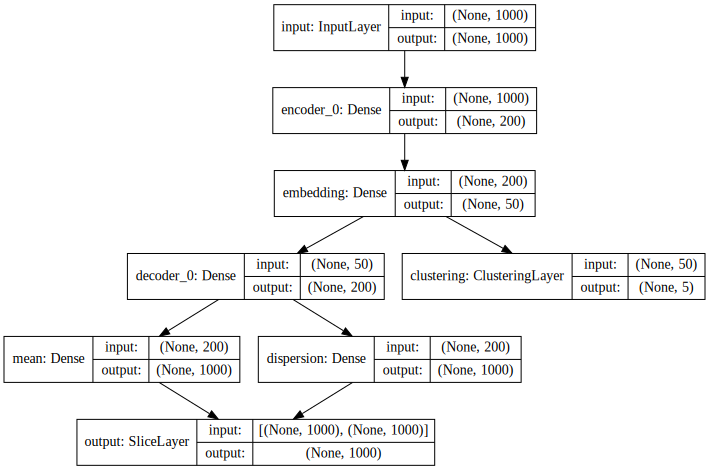

In [405]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [406]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.20) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


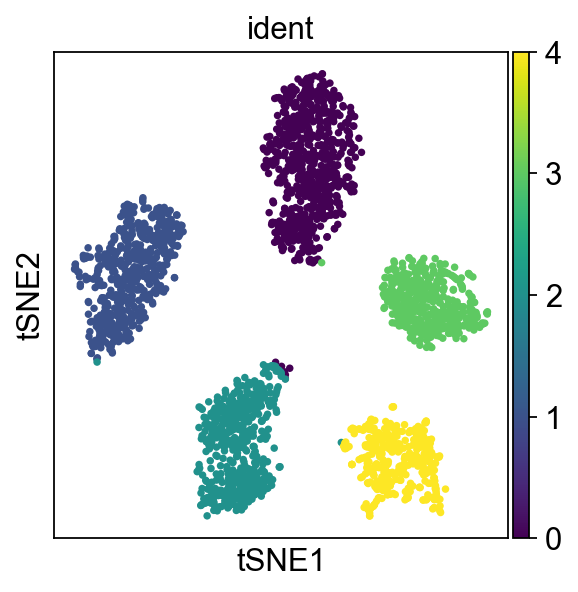

In [407]:
sc.pl.tsne(adata, color=['ident'])

NB with imputation lambda = 0.5

In [457]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="nb",impute=True,clust_weight=3,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with negative binomial loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 2s 884us/step - loss: 0.6721
Epoch 2/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3956
Epoch 3/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3727
Epoch 4/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3672
Epoch 5/300
2638/2638 [==============================] - 0s 110us/step - loss: 0.3654
Epoch 6/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3647
Epoch 7/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3631
Epoch 8/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3624
Epoch 9/300
2638/2638 [==============================] - 0s 109us/step - loss: 0.3612
Epoch 10/300
26

2638/2638 [==============================] - 0s 106us/step - loss: 0.3358
Epoch 93/300
2638/2638 [==============================] - 0s 106us/step - loss: 0.3360
Epoch 94/300
2638/2638 [==============================] - 0s 101us/step - loss: 0.3344
Epoch 95/300
2638/2638 [==============================] - 0s 101us/step - loss: 0.3359
Epoch 96/300
2638/2638 [==============================] - 0s 99us/step - loss: 0.3339
Epoch 97/300
2638/2638 [==============================] - 0s 101us/step - loss: 0.3355
Epoch 98/300
2638/2638 [==============================] - 0s 102us/step - loss: 0.3341
Epoch 99/300
2638/2638 [==============================] - 0s 104us/step - loss: 0.3345
Epoch 100/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3340
Epoch 101/300
2638/2638 [==============================] - 0s 108us/step - loss: 0.3338
Epoch 102/300
2638/2638 [==============================] - 0s 105us/step - loss: 0.3334
Epoch 103/300
2638/2638 [=============================

2638/2638 [==============================] - 0s 120us/step - loss: 0.3169
Epoch 186/300
2638/2638 [==============================] - 0s 119us/step - loss: 0.3172
Epoch 187/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.3171
Epoch 188/300
2638/2638 [==============================] - 0s 114us/step - loss: 0.3167
Epoch 189/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.3166
Epoch 190/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.3166
Epoch 191/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.3160
Epoch 192/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.3163
Epoch 193/300
2638/2638 [==============================] - 0s 114us/step - loss: 0.3157
Epoch 194/300
2638/2638 [==============================] - 0s 117us/step - loss: 0.3159
Epoch 195/300
2638/2638 [==============================] - 0s 114us/step - loss: 0.3154
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 116us/step - loss: 0.3020
Epoch 279/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.3011
Epoch 280/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.3014
Epoch 281/300
2638/2638 [==============================] - 0s 115us/step - loss: 0.3009
Epoch 282/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.3014
Epoch 283/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.3006
Epoch 284/300
2638/2638 [==============================] - 0s 118us/step - loss: 0.3005
Epoch 285/300
2638/2638 [==============================] - 0s 116us/step - loss: 0.3009
Epoch 286/300
2638/2638 [==============================] - 0s 117us/step - loss: 0.3002
Epoch 287/300
2638/2638 [==============================] - 0s 119us/step - loss: 0.3000
Epoch 288/300
2638/2638 [==============================] - 0s 119us/step - loss: 0.3005
Epoch 289/300
2638/2638 [=====================

The desc has been trained successfully!!!!!!
The summary of desc model is:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 1000)         0                                            
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 200)          200200      input[0][0]                      
__________________________________________________________________________________________________
embedding (Dense)               (None, 50)           10050       encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_0 (Dense)               (None, 200)          10200       embedding[0][0]                  
__________________________________

In [458]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.38) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


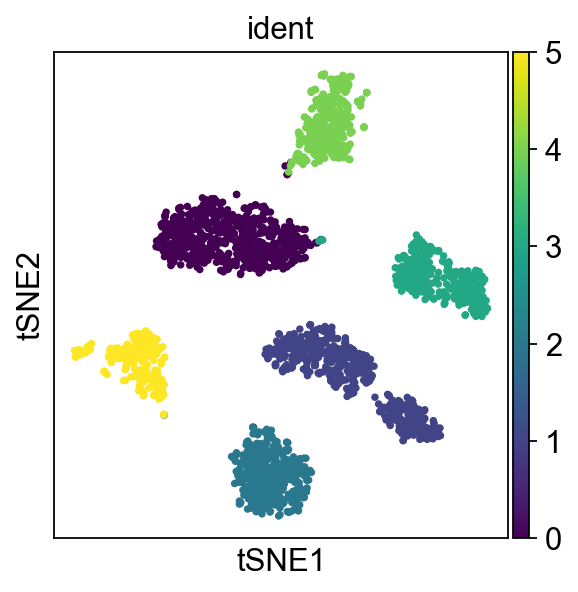

In [459]:
sc.pl.tsne(adata, color=['ident'])

Poisson no imputation.

In [408]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="poisson",impute=False,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 1s 561us/step - loss: -0.1788
Epoch 2/300
2638/2638 [==============================] - 0s 38us/step - loss: -0.9901
Epoch 3/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.0230
Epoch 4/300
2638/2638 [==============================] - 0s 41us/step - loss: -1.0515
Epoch 5/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.0720
Epoch 6/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.0842
Epoch 7/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.0947
Epoch 8/300
2638/2638 [==============================] - 0s 40us/step - loss: -1.1036
Epoch 9/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.1097
Epoch 10/300


2638/2638 [==============================] - 0s 38us/step - loss: -1.2785
Epoch 93/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.2800
Epoch 94/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2804
Epoch 95/300
2638/2638 [==============================] - 0s 35us/step - loss: -1.2804
Epoch 96/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.2839
Epoch 97/300
2638/2638 [==============================] - 0s 40us/step - loss: -1.2850
Epoch 98/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.2863
Epoch 99/300
2638/2638 [==============================] - 0s 42us/step - loss: -1.2826
Epoch 100/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.2892
Epoch 101/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.2869
Epoch 102/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.2885
Epoch 103/300
2638/2638 [============================

2638/2638 [==============================] - 0s 37us/step - loss: -1.3578
Epoch 186/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3554
Epoch 187/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3600
Epoch 188/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3575
Epoch 189/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.3610
Epoch 190/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3607
Epoch 191/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3605
Epoch 192/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3612
Epoch 193/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3643
Epoch 194/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3596
Epoch 195/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3642
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 36us/step - loss: -1.4074
Epoch 279/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4110
Epoch 280/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.4078
Epoch 281/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.4101
Epoch 282/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4096
Epoch 283/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4120
Epoch 284/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.4110
Epoch 285/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4119
Epoch 286/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.4111
Epoch 287/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4140 0s - loss: -1.41
Epoch 288/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4107
Epoch 289/300
2638/2638 [====

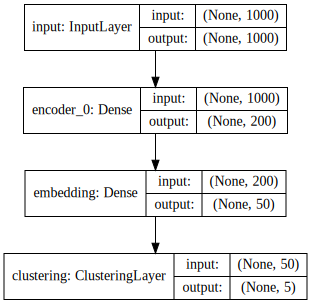

In [410]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [411]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:15.66) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


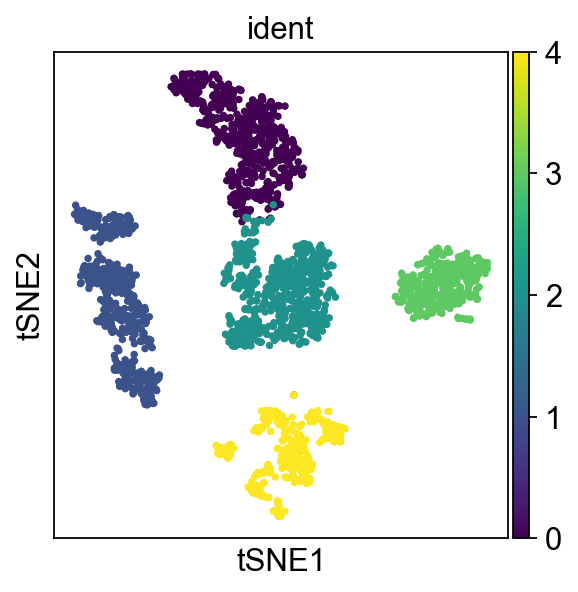

In [412]:
sc.pl.tsne(adata, color=['ident'])

Poisson with imputation.

In [417]:
adata, model = desc.train(adata, dims=[1000,200, 50], resolution=0.8,loss="poisson",impute=True,is_stacked=False,max_iter=20,pretrain_epochs=300)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/300
2638/2638 [==============================] - 2s 608us/step - loss: -0.1788
Epoch 2/300
2638/2638 [==============================] - 0s 39us/step - loss: -0.9901
Epoch 3/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.0227
Epoch 4/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.0493
Epoch 5/300
2638/2638 [==============================] - 0s 39us/step - loss: -1.0714
Epoch 6/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.0806
Epoch 7/300
2638/2638 [==============================] - 0s 41us/step - loss: -1.0943
Epoch 8/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.1008
Epoch 9/300
2638/2638 [==============================] - 0s 38us/step - loss: -1.1119
Epoch 10/300


2638/2638 [==============================] - 0s 37us/step - loss: -1.2832
Epoch 93/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.2841
Epoch 94/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.2831
Epoch 95/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2844
Epoch 96/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2882
Epoch 97/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2857
Epoch 98/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2899
Epoch 99/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.2891
Epoch 100/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.2898
Epoch 101/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2939
Epoch 102/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.2911
Epoch 103/300
2638/2638 [============================

2638/2638 [==============================] - 0s 37us/step - loss: -1.3619
Epoch 186/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3630
Epoch 187/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3632
Epoch 188/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3631
Epoch 189/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3649
Epoch 190/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3638
Epoch 191/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3671
Epoch 192/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3655
Epoch 193/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3680
Epoch 194/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.3673
Epoch 195/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.3685
Epoch 196/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 37us/step - loss: -1.4122
Epoch 279/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4126
Epoch 280/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.4145
Epoch 281/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4127
Epoch 282/300
2638/2638 [==============================] - 0s 36us/step - loss: -1.4154
Epoch 283/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4140
Epoch 284/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4167
Epoch 285/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4145
Epoch 286/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4171
Epoch 287/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4188
Epoch 288/300
2638/2638 [==============================] - 0s 37us/step - loss: -1.4145
Epoch 289/300
2638/2638 [=====================

2638/2638 [==============================] - 0s 37us/step - loss: -1.3373 - clustering_loss: 0.0635 - output_loss: -1.4008
Epoch 2/4
2638/2638 [==============================] - 0s 37us/step - loss: -1.3416 - clustering_loss: 0.0577 - output_loss: -1.3992
Epoch 3/4
2638/2638 [==============================] - 0s 38us/step - loss: -1.3438 - clustering_loss: 0.0550 - output_loss: -1.3988
Epoch 4/4
2638/2638 [==============================] - 0s 37us/step - loss: -1.3464 - clustering_loss: 0.0516 - output_loss: -1.3981
The value of delta_label of current 11 th iteration is 0.03828658074298711 >= tol 0.005
Epoch 1/4
2638/2638 [==============================] - 0s 36us/step - loss: -1.3250 - clustering_loss: 0.0706 - output_loss: -1.3956
Epoch 2/4
2638/2638 [==============================] - 0s 37us/step - loss: -1.3277 - clustering_loss: 0.0638 - output_loss: -1.3915
Epoch 3/4
2638/2638 [==============================] - 0s 38us/step - loss: -1.3336 - clustering_loss: 0.0606 - output_loss:

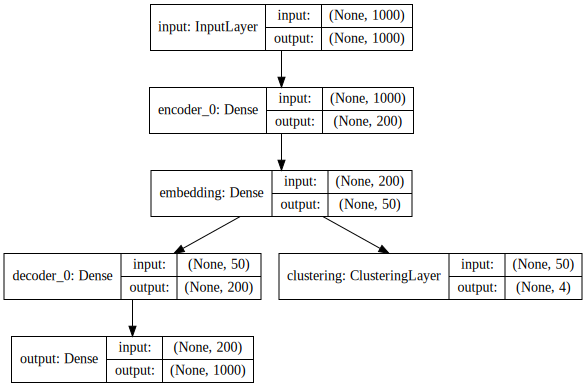

In [418]:
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [419]:
sc.tl.tsne(adata,use_rep="embedded")

computing tSNE
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished (0:00:16.57) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


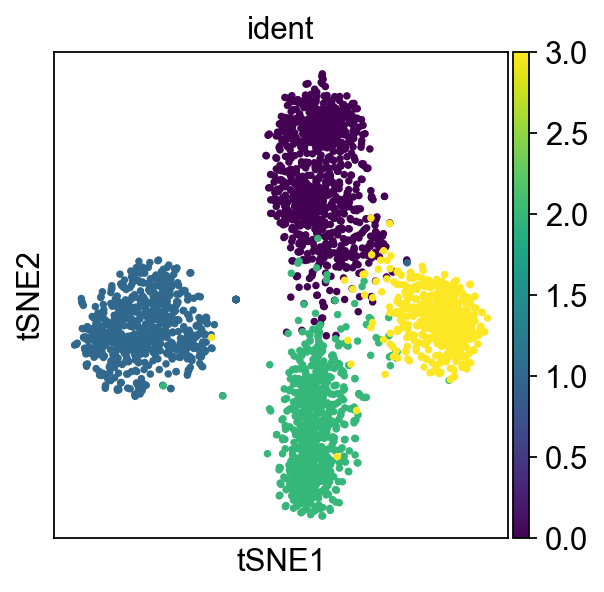

In [420]:
sc.pl.tsne(adata, color=['ident'])

## Mouse data with batches 

In [460]:
filenames = ['../Expression Matrices/M1r1',
             '../Expression Matrices/M1r2',
             '../Expression Matrices/M2r1',
             '../Expression Matrices/M2r2',
             '../Expression Matrices/M3r1',
             '../Expression Matrices/M3r2',
             '../Expression Matrices/M4r1',
             '../Expression Matrices/M4r2',
             '../Expression Matrices/M5r1',
             '../Expression Matrices/M6r1',
            ]
adatas = [sc.read_10x_mtx(filename,var_names='gene_symbols',cache=True) for filename in filenames]
adata = adatas[0].concatenate(adatas[1:])

... reading from cache file ./cache/Expression Matrices-M1r1-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M1r2-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M2r1-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M2r2-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M3r1-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M3r2-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M4r1-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M4r2-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M5r1-matrix.h5ad
... reading from cache file ./cache/Expression Matrices-M6r1-matrix.h5ad


In [461]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

In [462]:
adata

AnnData object with n_obs × n_vars = 102849 × 27998 
    obs: 'batch'
    var: 'gene_ids-0', 'gene_ids-1', 'gene_ids-2', 'gene_ids-3', 'gene_ids-4', 'gene_ids-5', 'gene_ids-6', 'gene_ids-7', 'gene_ids-8', 'gene_ids-9'

In [463]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 352 cells that have less than 200 genes expressed
filtered out 8570 genes that are detected in less than 3 cells


In [464]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.sum(adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

In [465]:
adata = adata[adata.obs['n_genes'] < 2500, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

In [466]:
sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)

In [468]:
data = adata.X.todense()
data = data[:,np.where(np.sum(data,axis=0) > 10)[1]]
data[np.nonzero(data) == False] = np.nan
highly_var_genes = np.nanvar(data,axis=0).tolist()[0]
highly_var_genes_idx = np.argsort(highly_var_genes)
highly_var_genes_idx = highly_var_genes_idx[-300:]
adata = adata[:,highly_var_genes_idx]

In [471]:
adata, model = desc.train(adata, dims=[300, 128, 32], resolution=0.8,loss="poisson",impute=True,is_stacked=False,max_iter=10,pretrain_epochs=100)

The number of threads in your computer is 12
The number of threads used is 4
Created autoencoder with mean squared error loss.
Checking whether tmp_result/ae_weights,h5  exists in the directory
learning rate = 1
Epoch 1/100
101735/101735 [==============================] - 4s 38us/step - loss: -0.7079
Epoch 2/100
101735/101735 [==============================] - 2s 18us/step - loss: -0.8618
Epoch 3/100
101735/101735 [==============================] - 2s 17us/step - loss: -0.9091
Epoch 4/100
101735/101735 [==============================] - 2s 18us/step - loss: -0.9406
Epoch 5/100
101735/101735 [==============================] - 2s 18us/step - loss: -0.9647
Epoch 6/100
101735/101735 [==============================] - 2s 18us/step - loss: -0.9866
Epoch 7/100
101735/101735 [==============================] - 2s 18us/step - loss: -1.0057
Epoch 8/100
101735/101735 [==============================] - 2s 18us/step - loss: -1.0226
Epoch 9/100
101735/101735 [==============================] - 2s 18us

101735/101735 [==============================] - 2s 19us/step - loss: -1.2197
Epoch 89/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2205
Epoch 90/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2213
Epoch 91/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2221
Epoch 92/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2228
Epoch 93/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2234
Epoch 94/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2241
Epoch 95/100
101735/101735 [==============================] - 2s 18us/step - loss: -1.2250
Epoch 96/100
101735/101735 [==============================] - 2s 18us/step - loss: -1.2257
Epoch 97/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2263
Epoch 98/100
101735/101735 [==============================] - 2s 19us/step - loss: -1.2269
Epoch 99/100

The desc has been trained successfully!!!!!!
The summary of desc model is:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 300)          0                                            
__________________________________________________________________________________________________
encoder_0 (Dense)               (None, 128)          38528       input[0][0]                      
__________________________________________________________________________________________________
embedding (Dense)               (None, 32)           4128        encoder_0[0][0]                  
__________________________________________________________________________________________________
decoder_0 (Dense)               (None, 128)          4224        embedding[0][0]                  
__________________________________

In [473]:
sc.tl.tsne(adata,use_rep="embedded")

TypeError: pca() got an unexpected keyword argument 'use_rep'

In [ ]:
sc.pl.tsne(adata, color=['ident','batch'])

## Finding marker genes

Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

ranking genes
    finished (0:00:00.70) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


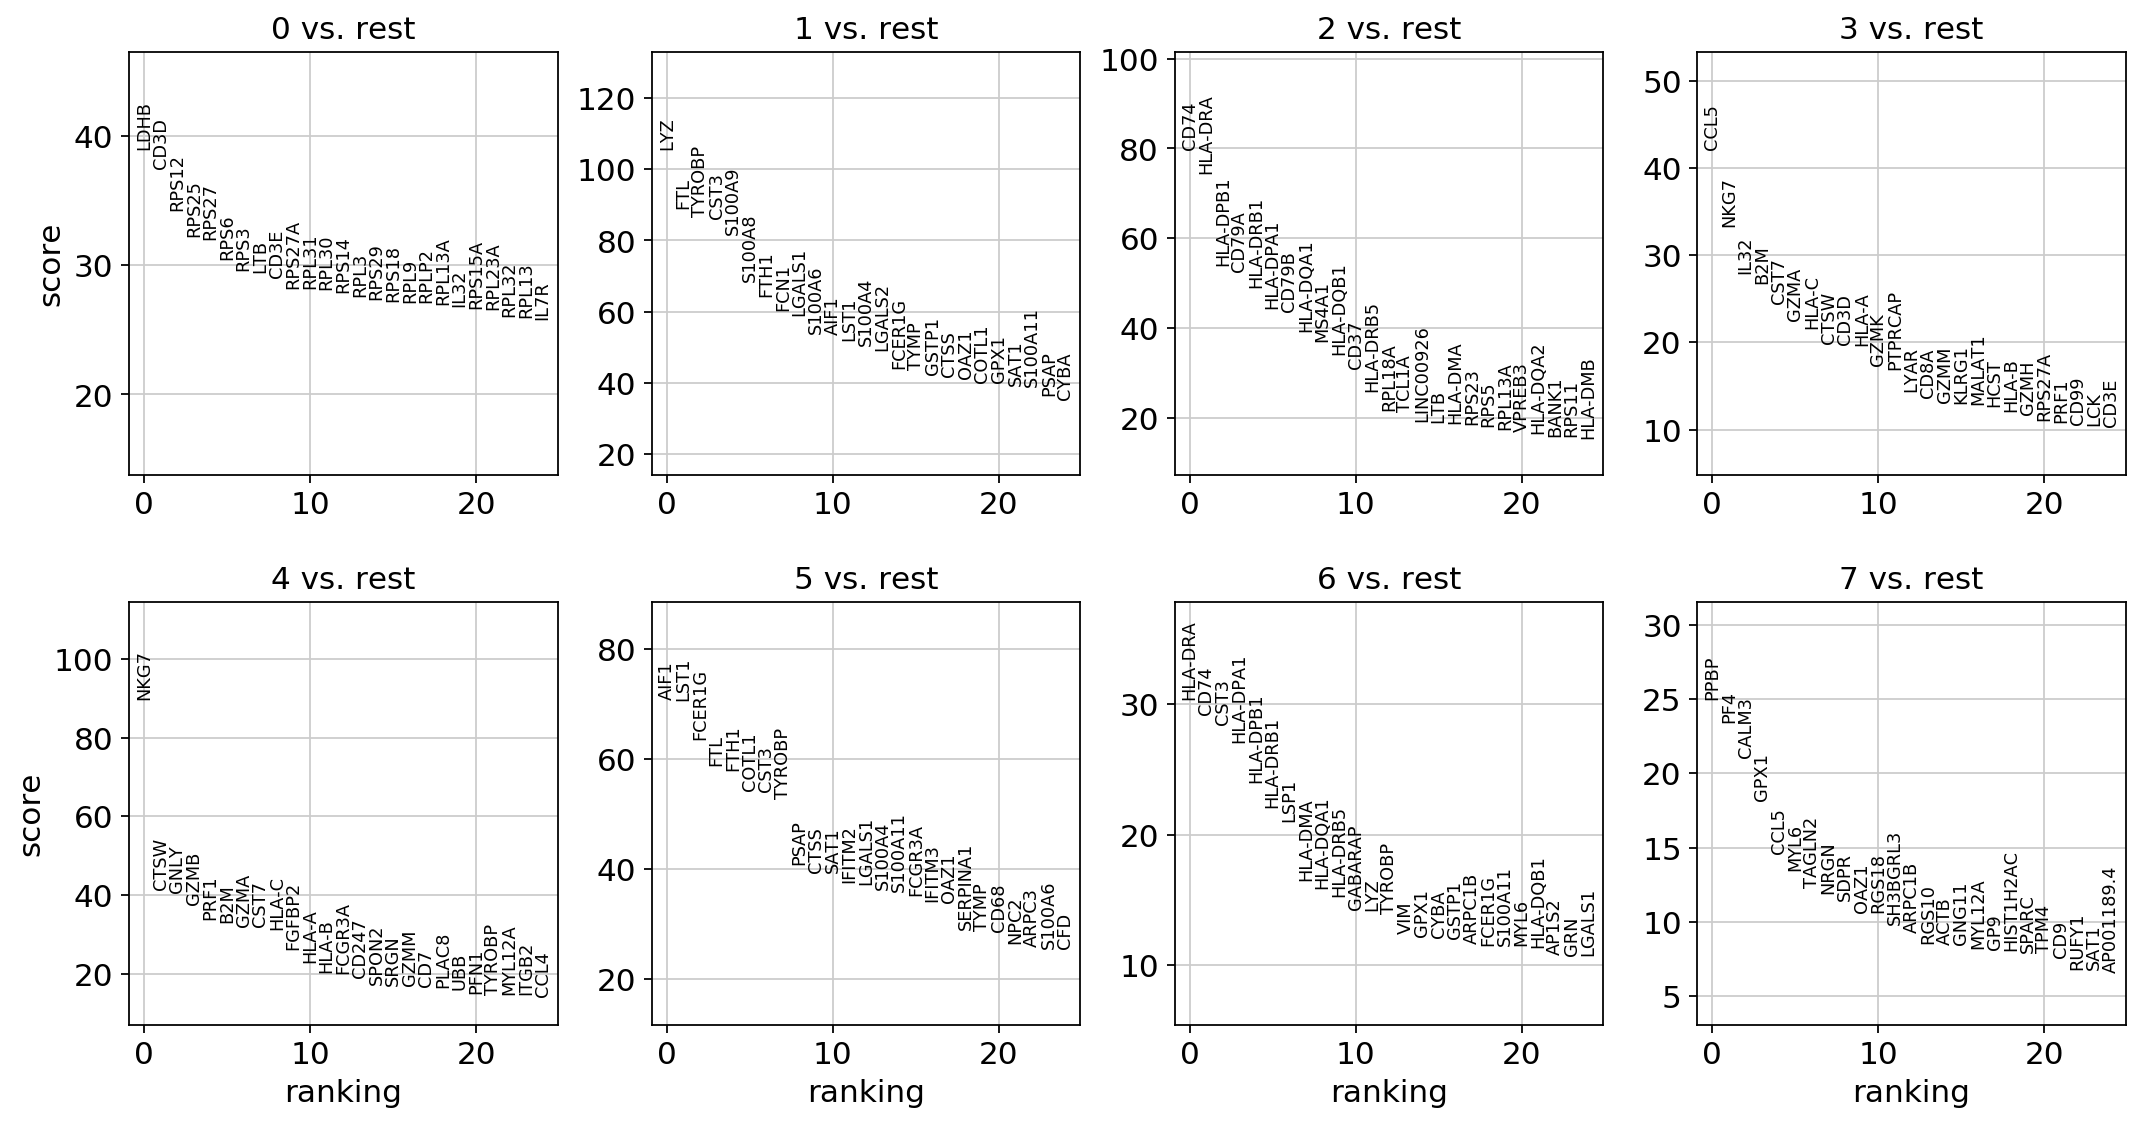

In [33]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [34]:
sc.settings.verbosity = 2  # reduce the verbosity

The result of a [Wilcoxon rank-sum (Mann-Whitney-U)](https://de.wikipedia.org/wiki/Wilcoxon-Mann-Whitney-Test) test is very similar. We recommend using the latter in publications, see e.g., [Sonison & Robinson (2018)](https://doi.org/10.1038/nmeth.4612). You might also consider much more powerful differential testing packages like MAST, limma, DESeq2 and, for python, the recent diffxpy.

ranking genes
    finished (0:00:02.77)


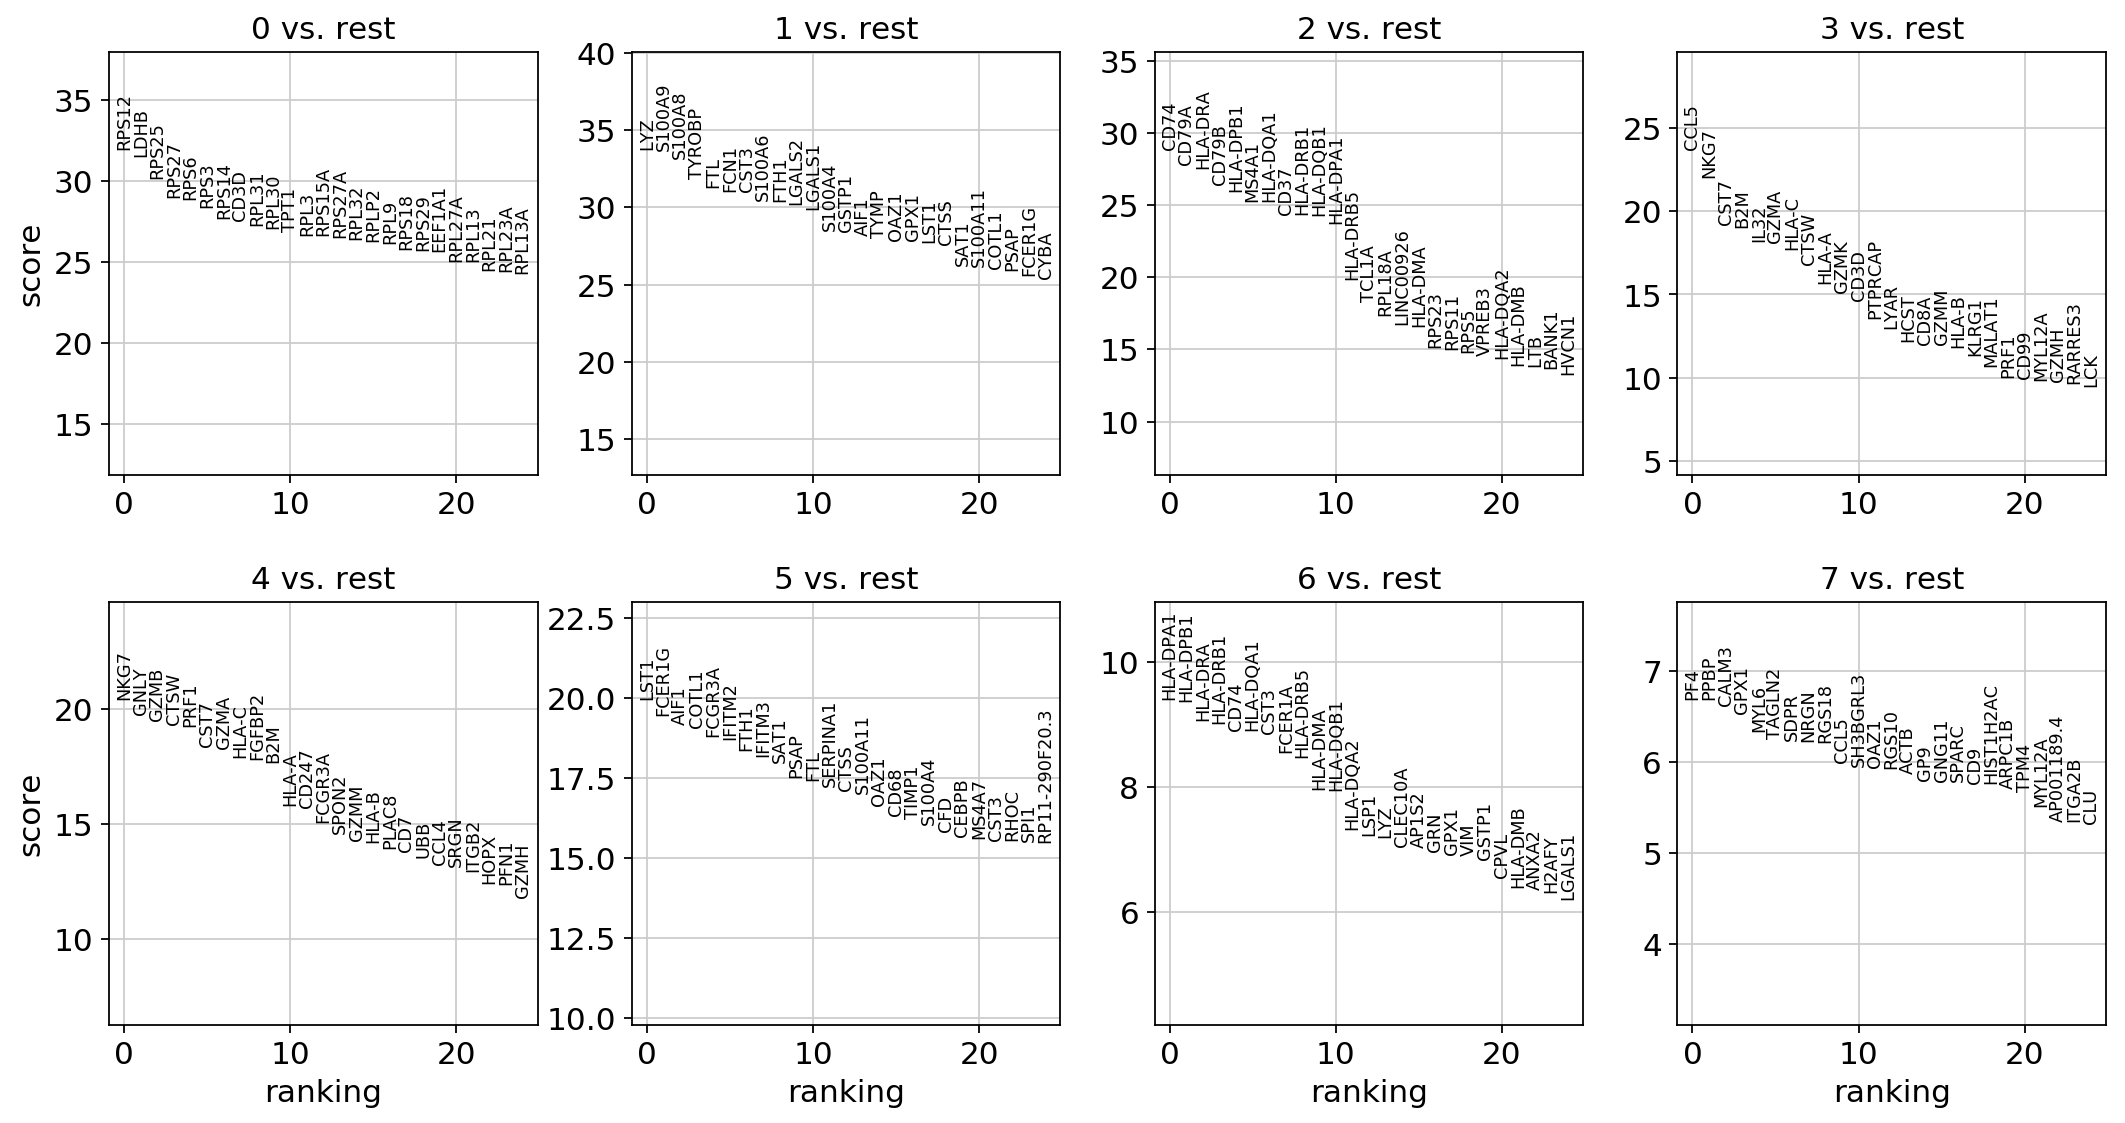

In [35]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Save the result.

In [36]:
adata.write(results_file)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by [Natranos et al. (2018)](https://doi.org/10.1101/258566). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. [Clark et al. (2014)](https://doi.org/10.1186/1471-2105-15-79) has more details.

ranking genes
    finished (0:00:03.43)


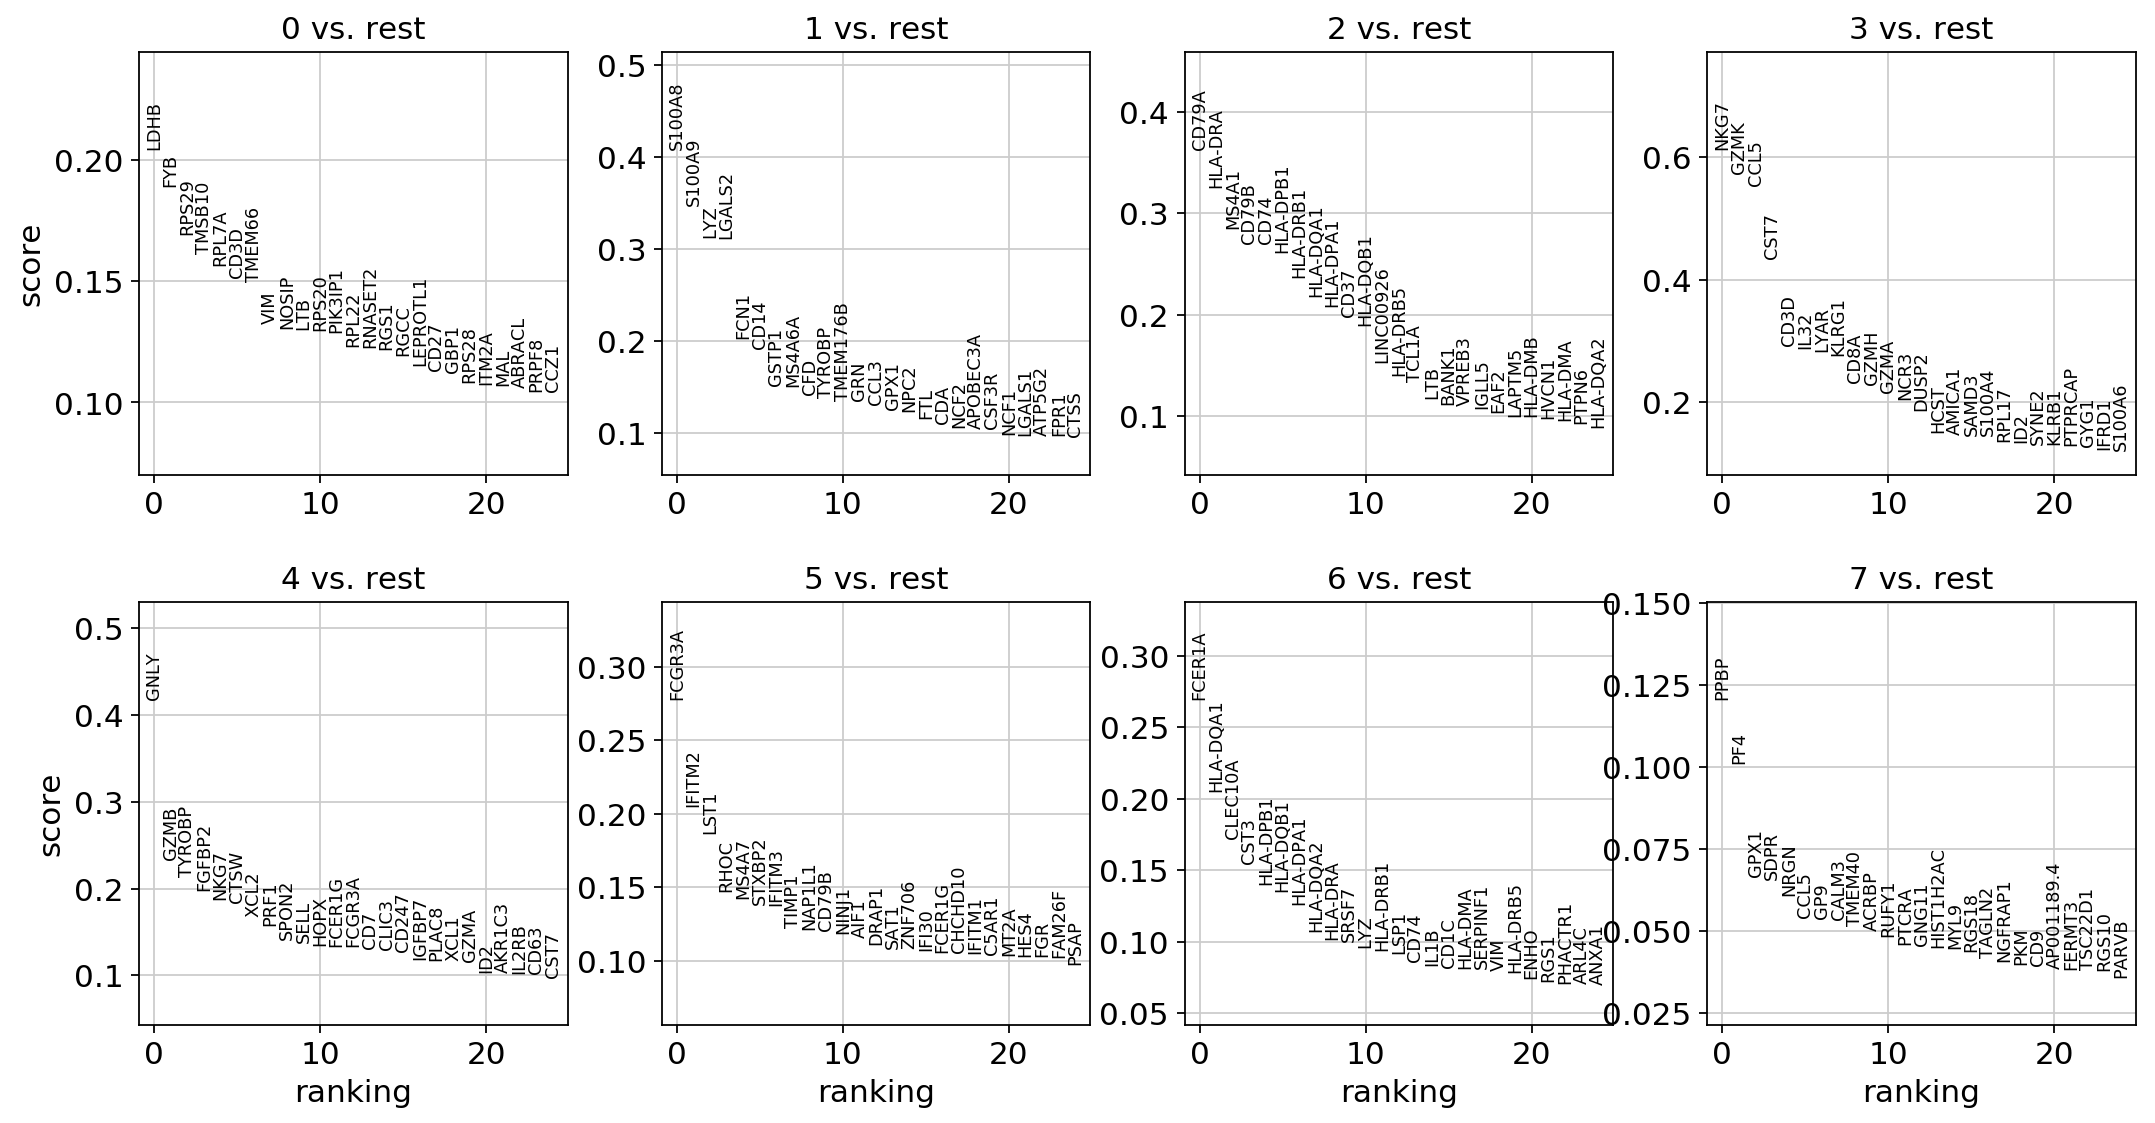

In [37]:
sc.tl.rank_genes_groups(adata, 'louvain', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of *IL7R*, which is only found by the t-test and *FCER1A*, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

Louvain Group | Markers | Cell Type
---|---|---
0 | IL7R | CD4 T cells
1 | CD14, LYZ | CD14+ Monocytes
2 | MS4A1 |	B cells
3 | CD8A |	CD8 T cells
4 | GNLY, NKG7 | 	NK cells
5 | FCGR3A, MS4A7 |	FCGR3A+ Monocytes
6 | FCER1A, CST3 |	Dendritic Cells
7 | PPBP |	Megakaryocytes

Let us also define a list of marker genes for later reference.

In [38]:
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',  
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

Reload the object that has been save with the Wilcoxon Rank-Sum test result.

In [39]:
adata = sc.read(results_file)

Show the 10 top ranked genes per cluster 0, 1, ..., 7 in a dataframe.

In [40]:
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

0       1         2     3     4       5         6      7
0  RPS12     LYZ      CD74  CCL5  NKG7    LST1  HLA-DPA1    PF4
1   LDHB  S100A9     CD79A  NKG7  GNLY  FCER1G  HLA-DPB1   PPBP
2  RPS25  S100A8   HLA-DRA  CST7  GZMB    AIF1   HLA-DRA  CALM3
3  RPS27  TYROBP     CD79B   B2M  CTSW   COTL1  HLA-DRB1   GPX1
4   RPS6     FTL  HLA-DPB1  IL32  PRF1  FCGR3A      CD74   MYL6

Get a table with the scores and groups.

In [41]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(5)

0_n            0_p     1_n            1_p       2_n            2_p   3_n  \
0  RPS12  2.556578e-224     LYZ  9.570840e-250      CD74  2.487145e-183  CCL5   
1   LDHB  2.944386e-218  S100A9  7.389959e-249     CD79A  1.679730e-170  NKG7   
2  RPS25  2.120418e-200  S100A8  7.549245e-241   HLA-DRA  6.942399e-167  CST7   
3  RPS27  8.086262e-185  TYROBP  1.131467e-222     CD79B  2.569135e-154   B2M   
4   RPS6  1.546041e-183     FTL  2.689949e-215  HLA-DPB1  3.580735e-148  IL32   

             3_p   4_n           4_p     5_n           5_p       6_n  \
0  2.432069e-124  NKG7  7.238180e-93    LST1  1.229764e-88  HLA-DPA1   
1  2.002395e-107  GNLY  3.627599e-87  FCER1G  3.430812e-84  HLA-DPB1   
2   2.524340e-82  GZMB  5.161534e-85    AIF1  5.144661e-82   HLA-DRA   
3   6.714479e-81  CTSW  2.012053e-83   COTL1  4.761217e-81  HLA-DRB1   
4   6.623479e-74  PRF1  1.353268e-82  FCGR3A  8.812368e-79      CD74   

            6_p    7_n           7_p  
0  5.422417e-21    PF4  2.264925e-11  
1  7.591860e-21   PPBP  2.264925e-11  
2  1.306768e-19  CALM3  3.591608e-11  
3  1.865104e-19   GPX1  6.352631e-11  
4  5.853161e-19   MYL6  2.432291e-10

Compare to a single cluster. 

ranking genes
    finished (0:00:01.26)


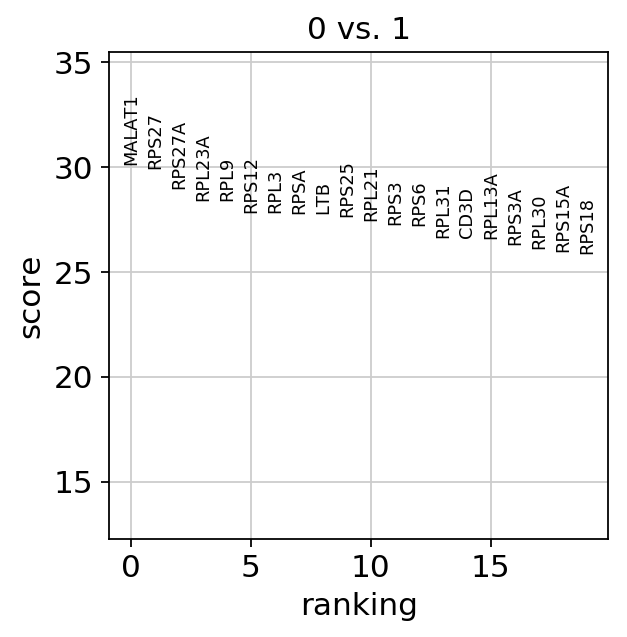

In [42]:
sc.tl.rank_genes_groups(adata, 'louvain', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=20)

If we want a more detailed view for a certain group, use `sc.pl.rank_genes_groups_violin`.

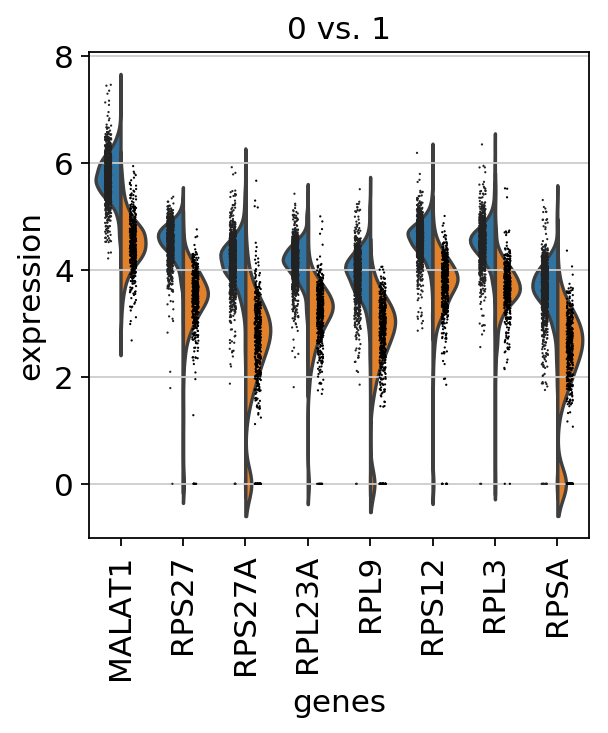

In [43]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

Reload the object that computed differential expression by comparing to the rest of the groups.

In [44]:
adata = sc.read(results_file)

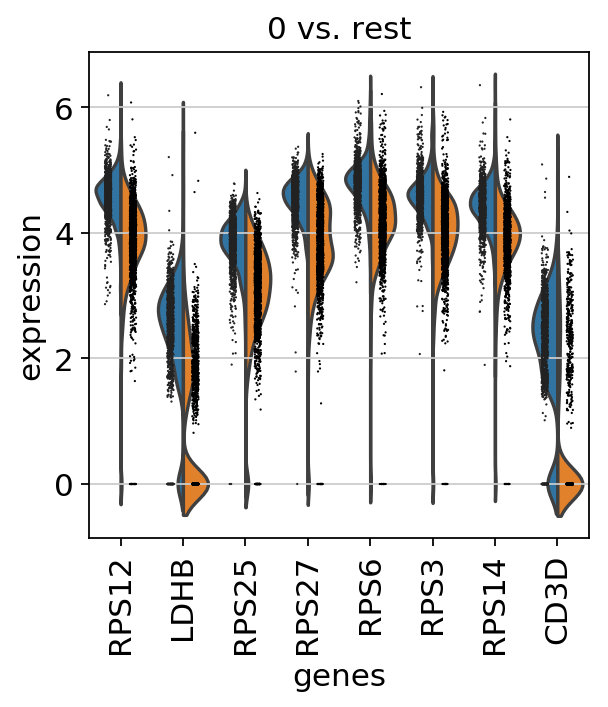

In [45]:
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=8)

If you want to compare a certain gene across groups, use the following.

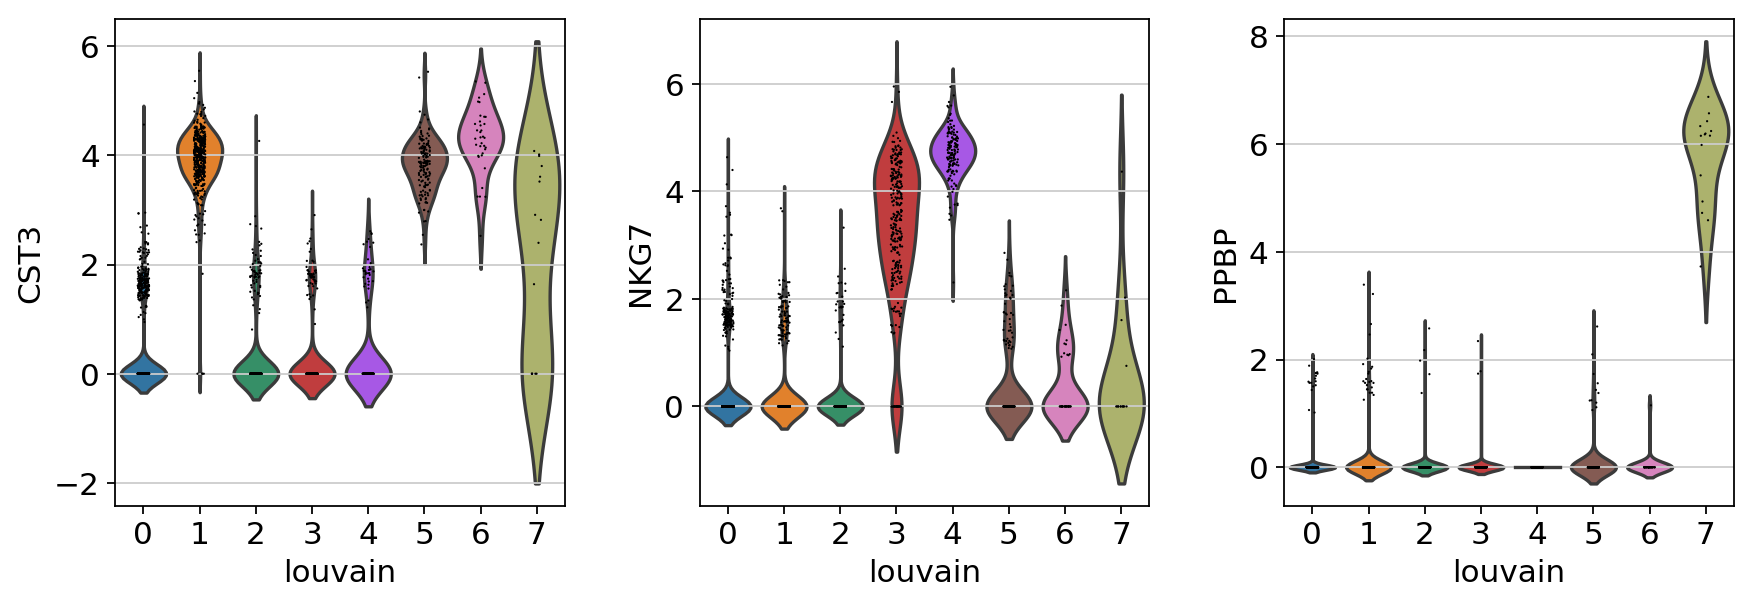

In [46]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='louvain')

Actually mark the cell types.

In [47]:
new_cluster_names = [
    'CD4 T', 'CD14+ Monocytes',
    'B', 'CD8 T', 
    'NK', 'FCGR3A+ Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('louvain', new_cluster_names)

saving figure to file ./figures/umap.pdf


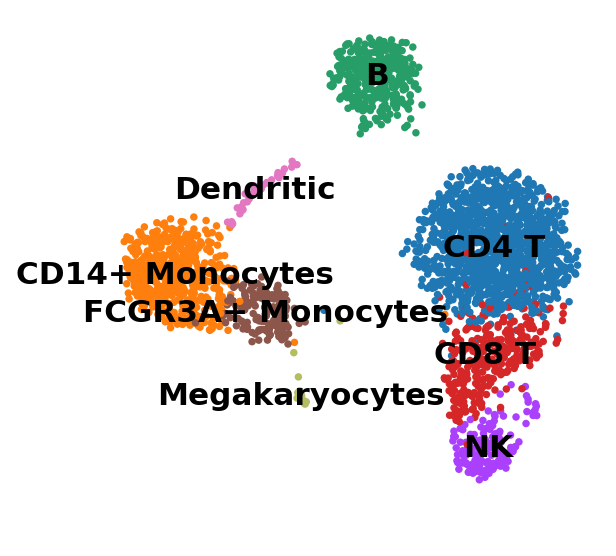

In [48]:
sc.pl.umap(adata, color='louvain', legend_loc='on data', title='', frameon=False, save='.pdf')

Now that we annotated the cell types, let us visualize the marker genes.

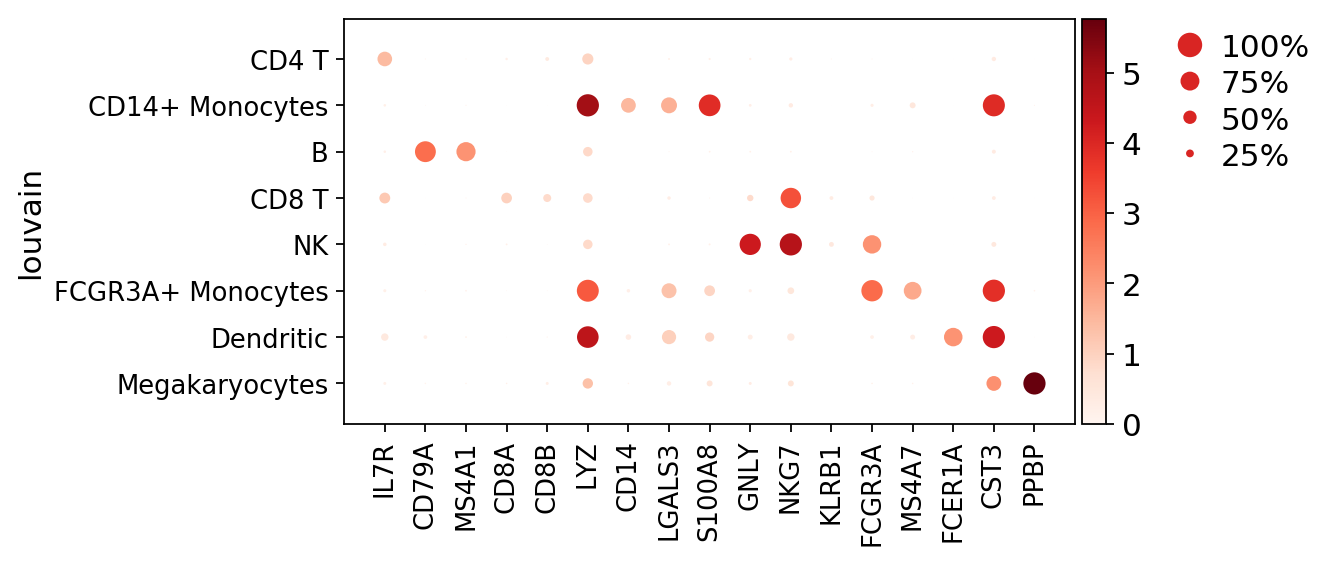

In [49]:
ax = sc.pl.dotplot(adata, marker_genes, groupby='louvain')

There is also a very compact violin plot.

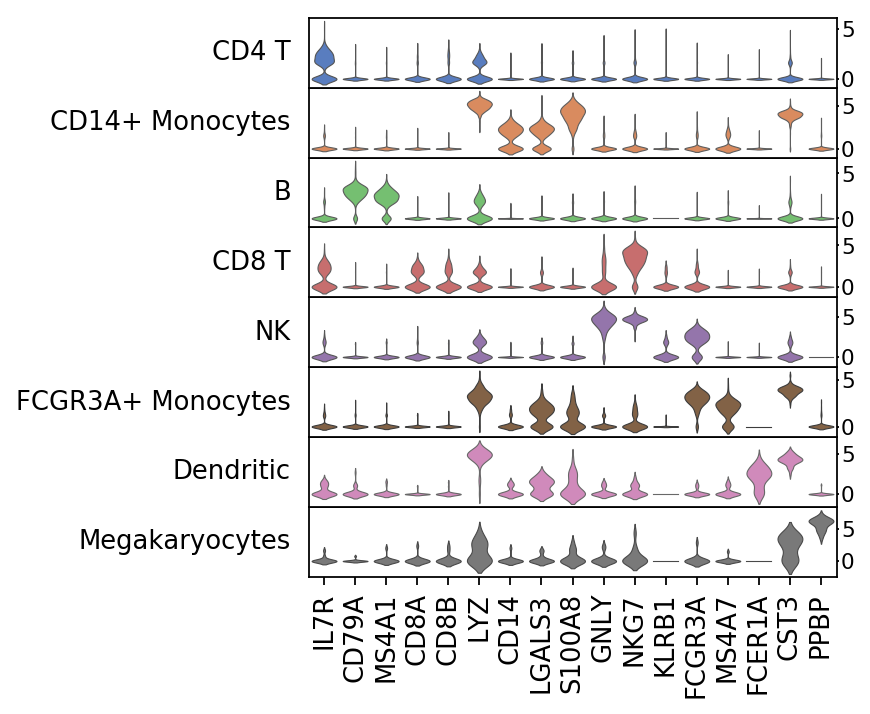

In [50]:
ax = sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)

During the course of this analysis, the AnnData accumlated the following annotations.

In [51]:
adata

AnnData object with n_obs × n_vars = 2638 × 1838 
    obs: 'n_genes', 'percent_mito', 'n_counts', 'louvain'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'louvain', 'louvain_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [52]:
adata.write(results_file, compression='gzip')  # `compression='gzip'` saves disk space, but slows down writing and subsequent reading

Get a rough overview of the file using `h5ls`, which has many options - for more details see [here](https://github.com/theislab/scanpy_usage/blob/master/170505_seurat/info_h5ad.md). The file format might still be subject to further optimization in the future. All reading functions will remain backwards-compatible, though.

If you want to share this file with people who merely want to use it for visualization, a simple way to reduce the file size is by removing the dense scaled and corrected data matrix. The file still contains the raw data used in the visualizations.

In [53]:
adata.X = None
adata.write('./write/pbmc3k_withoutX.h5ad', compression='gzip')

If you want to export to "csv", you have the following options:

In [54]:
# Export single fields of the annotation of observations
# adata.obs[['n_counts', 'louvain_groups']].to_csv(
#     './write/pbmc3k_corrected_louvain_groups.csv')

# Export single columns of the multidimensional annotation
# adata.obsm.to_df()[['X_pca1', 'X_pca2']].to_csv(
#     './write/pbmc3k_corrected_X_pca.csv')

# Or export everything except the data using `.write_csvs`.
# Set `skip_data=False` if you also want to export the data.
# adata.write_csvs(results_file[:-5], )